# Lab 3: Computing Bottom-Up Emissions
## Case Study: China Steel Industry (2020-2030)

## 1. Setup and Imports

In [129]:
!uv pip install pandas numpy matplotlib seaborn scikit-learn

Audited 5 packages in 22ms


In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [131]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Data Loading

In [132]:
data_path = '../Lab1/processed_data/steel_plants_cleaned.csv'
df = pd.read_csv(data_path)

In [133]:
print(f"Total plants in dataset: {len(df)}")
print(f"Columns: {df.columns.tolist()[:10]}...")
df.head(3)

Total plants in dataset: 868
Columns: ['Plant ID', 'Plant name (English)', 'Plant name (other language)', 'Other plant names (English)', 'Other plant names (other language)', 'Owner', 'Owner (other language)', 'Owner GEM ID', 'Owner PermID', 'SOE Status']...


,Plant ID,Plant name (English),Plant name (other language),Other plant names (English),Other plant names (other language),Owner,Owner (other language),Owner GEM ID,Owner PermID,SOE Status,...,Nominal EAF steel capacity (ttpa),Nominal OHF steel capacity (ttpa),Other/unspecified steel capacity (ttpa),Nominal iron capacity (ttpa),Nominal BF capacity (ttpa),Nominal DRI capacity (ttpa),Other/unspecified iron capacity (ttpa),latitude,longitude,age_category
0,P100000120439,Algerian Qatari Steel Jijel plant,الجزائرية القطرية للصلب,AQS,NaN,Algerian Qatari Steel,NaN,E100001000957,5076384326,Partial,...,2200.0,NaN,NaN,2500,NaN,2500,NaN,36.753961,6.244420,0-10 years
1,P100000121198,Ozmert Algeria steel plant,NaN,NaN,NaN,Ozmert Algeria SARL,NaN,E100001012196,unknown,NaN,...,800.0,NaN,NaN,500,NaN,500,NaN,35.478580,-0.621390,NaN
2,P100000120440,Sider El Hadjar Annaba steel plant,مركب الحجار للحديد والصلب,"ArcelorMittal Annaba (predecessor), El Hadjar ...",NaN,Groupe Industriel Sider SpA,NaN,E100001000960,5000941519,Full,...,1800.0,NaN,NaN,1500,1500.0,NaN,NaN,36.795924,7.707633,51-100 years


In [134]:
china_plants = df[df['Country/Area'] == 'China'].copy()
print(f"China plants: {len(china_plants)}")
print(f"\nCapacity completeness:")
print(f"  Crude steel capacity: {china_plants['Nominal crude steel capacity (ttpa)'].notna().sum()}/{len(china_plants)} ({china_plants['Nominal crude steel capacity (ttpa)'].notna().sum()/len(china_plants)*100:.1f}%)")
print(f"  BOF capacity: {china_plants['Nominal BOF steel capacity (ttpa)'].notna().sum()}/{len(china_plants)} ({china_plants['Nominal BOF steel capacity (ttpa)'].notna().sum()/len(china_plants)*100:.1f}%)")
print(f"  EAF capacity: {china_plants['Nominal EAF steel capacity (ttpa)'].notna().sum()}/{len(china_plants)} ({china_plants['Nominal EAF steel capacity (ttpa)'].notna().sum()/len(china_plants)*100:.1f}%)")

China plants: 289

Capacity completeness:
  Crude steel capacity: 272/289 (94.1%)
  BOF capacity: 195/289 (67.5%)
  EAF capacity: 106/289 (36.7%)


In [135]:
total_china_capacity = china_plants['Nominal crude steel capacity (ttpa)'].sum() / 1e6
print(f"\nTotal China capacity in dataset: {total_china_capacity:.2f} Mt")
print(f"Actual China steel capacity (~2020): ~1,000 Mt")
print(f"Dataset coverage: {total_china_capacity/1000*100:.2f}%")


Total China capacity in dataset: 0.96 Mt
Actual China steel capacity (~2020): ~1,000 Mt
Dataset coverage: 0.10%


## 2.1 Data Quality Assessment

## 3. Date Processing and Operating Status

In [136]:
df['start_date'] = pd.to_datetime(df['Start date'], errors='coerce')
df['end_date'] = pd.to_datetime(df['Retired date'], errors='coerce')
df['start_year'] = df['start_date'].dt.year
df['end_year'] = df['end_date'].dt.year

In [137]:
years = range(2020, 2031)
plant_years = []

for year in years:
    df_year = df.copy()
    df_year['year'] = year
    
    df_year['is_operating'] = (
        (df_year['start_year'] <= year) | (df_year['start_year'].isna())
    ) & (
        (df_year['end_year'] > year) | (df_year['end_year'].isna())
    )
    
    plant_years.append(df_year)

df_expanded = pd.concat(plant_years, ignore_index=True)

In [138]:
df_operating = df_expanded[df_expanded['is_operating']].copy()
print(f"Operating plant-years: {len(df_operating)}")

Operating plant-years: 9453


## 4. Technology Type Classification

In [139]:
df_operating['bof_capacity'] = pd.to_numeric(
    df_operating['Nominal BOF steel capacity (ttpa)'], 
    errors='coerce'
).fillna(0)

df_operating['eaf_capacity'] = pd.to_numeric(
    df_operating['Nominal EAF steel capacity (ttpa)'], 
    errors='coerce'
).fillna(0)

df_operating['total_capacity'] = pd.to_numeric(
    df_operating['Nominal crude steel capacity (ttpa)'], 
    errors='coerce'
).fillna(0)

In [140]:
def classify_technology(row):
    if row['bof_capacity'] > row['eaf_capacity']:
        return 'BF-BOF'
    elif row['eaf_capacity'] > 0:
        return 'EAF'
    else:
        return 'Unknown'

df_operating['technology'] = df_operating.apply(classify_technology, axis=1)

In [141]:
print("Technology distribution:")
print(df_operating.groupby('technology')['total_capacity'].sum() / 1e6)

Technology distribution:
technology
BF-BOF     14.636641
EAF         6.977490
Unknown     0.276549
Name: total_capacity, dtype: float64


## 5. China Case Study - Filter Data

In [142]:
df_china = df_operating[df_operating['Country/Area'] == 'China'].copy()
print(f"Chinese plants (plant-years): {len(df_china)}")
print(f"Unique plants: {df_china['Plant ID'].nunique()}")

Chinese plants (plant-years): 3140
Unique plants: 289


In [143]:
china_capacity_by_tech = df_china.groupby(['year', 'technology'])['total_capacity'].sum() / 1e6
print("\nChina capacity by technology (Mt):")
print(china_capacity_by_tech.unstack())


China capacity by technology (Mt):
technology    BF-BOF       EAF  Unknown
year                                   
2020        0.813573  0.090703      0.0
2021        0.826297  0.095103      0.0
2022        0.848069  0.095603      0.0
2023        0.848069  0.107171      0.0
2024        0.848069  0.107171      0.0
2025        0.848069  0.107171      0.0
2026        0.848069  0.107171      0.0
2027        0.848069  0.107171      0.0
2028        0.848069  0.107171      0.0
2029        0.848069  0.107171      0.0
2030        0.848069  0.107171      0.0


## 6. Utilization Rate Calculation (World Steel Association + OECD)

In [144]:
production_data_wsa = {
    2020: 1053, 2021: 1033, 2022: 1013, 2023: 1019
}

capacity_data_oecd = {
    2020: 1080, 2021: 1090, 2022: 1100, 2023: 1110
}

utilization_by_year = {}
for year in production_data_wsa.keys():
    utilization_by_year[year] = production_data_wsa[year] / capacity_data_oecd[year]

print("Country-level utilization rates (Production/Capacity):")
for year, util in utilization_by_year.items():
    print(f"  {year}: {util:.3f} ({util*100:.1f}%)")

avg_utilization = np.mean(list(utilization_by_year.values()))
print(f"\nAverage utilization (2020-2023): {avg_utilization:.3f} ({avg_utilization*100:.1f}%)")

Country-level utilization rates (Production/Capacity):
  2020: 0.975 (97.5%)
  2021: 0.948 (94.8%)
  2022: 0.921 (92.1%)
  2023: 0.918 (91.8%)

Average utilization (2020-2023): 0.940 (94.0%)


### Methodological Choice: Technology-Level vs Country-Level Rates

The country-level utilization rate calculated above (~93% average for 2020-2023) represents China's overall steel industry performance. However, the guidelines suggest "a more granular approach consists in using technology level utilization rates."

We adopt the **technology-level approach** because:
- **BF-BOF plants** operate continuously with high utilization (~82%)
- **EAF plants** operate intermittently with lower utilization (~73%) due to power availability and scrap supply constraints
- This differentiation provides more accurate plant-level estimates

The technology-specific rates used below are based on China Iron and Steel Association industry reports (2020-2022).

In [145]:
utilization_rates = {
    'BF-BOF': 0.82,
    'EAF': 0.73,
    'Unknown': 0.75
}

print("Technology-level utilization rates (more granular approach):")
print(f"  BF-BOF: {utilization_rates['BF-BOF']} (82%)")
print(f"  EAF: {utilization_rates['EAF']} (73%)")
print(f"\nNote: BF-BOF has higher utilization due to continuous operation.")
print("EAF has lower utilization due to intermittent operation and power constraints.")

Technology-level utilization rates (more granular approach):
  BF-BOF: 0.82 (82%)
  EAF: 0.73 (73%)

Note: BF-BOF has higher utilization due to continuous operation.
EAF has lower utilization due to intermittent operation and power constraints.


In [146]:
df_china['utilization_rate'] = df_china['technology'].map(utilization_rates)
df_china['production'] = df_china['total_capacity'] * df_china['utilization_rate']

## 7. Emissions Factors (Hasanbeigi Report)

In [147]:
emissions_factors = {
    'BF-BOF': 2.1,
    'EAF': 0.5,
    'Unknown': 1.5
}

print("Emissions factors (tCO2/tonne steel):")
print(f"  BF-BOF: {emissions_factors['BF-BOF']} tCO2/t")
print(f"  EAF: {emissions_factors['EAF']} tCO2/t")
print("\nSource: Hasanbeigi et al. (2016), 'Comparison of Iron and Steel Production")
print("Energy Use and Energy Intensity in China and the U.S.'")
print("Lawrence Berkeley National Laboratory Report")
print("\nBF-BOF includes integrated blast furnace route with basic oxygen furnace.")
print("EAF includes electric arc furnace with grid electricity emissions.")

Emissions factors (tCO2/tonne steel):
  BF-BOF: 2.1 tCO2/t
  EAF: 0.5 tCO2/t

Source: Hasanbeigi et al. (2016), 'Comparison of Iron and Steel Production
Energy Use and Energy Intensity in China and the U.S.'
Lawrence Berkeley National Laboratory Report

BF-BOF includes integrated blast furnace route with basic oxygen furnace.
EAF includes electric arc furnace with grid electricity emissions.


In [148]:
emissions_factors = {
    'BF-BOF': 2.1,
    'EAF': 0.5,
    'Unknown': 1.5
}

In [149]:
df_china['emissions_factor'] = df_china['technology'].map(emissions_factors)
df_china['emissions'] = df_china['production'] * df_china['emissions_factor']

In [150]:
print("\nSample plant-level calculations:")
print(df_china[[
    'Plant name (English)', 'year', 'technology', 
    'total_capacity', 'production', 'emissions'
]].head())


Sample plant-level calculations:
                          Plant name (English)  year technology  \
61  Angang Group Xinyang Iron and Steel Co Ltd  2020     BF-BOF   
62     Angang Lianzhong Stainless Steel Co Ltd  2020        EAF   
63                         Angang Steel Co Ltd  2020     BF-BOF   
64         Angang Steel Co Ltd Bayuquan branch  2020     BF-BOF   
65               Anhui Changjiang Steel Co Ltd  2020     BF-BOF   

    total_capacity  production  emissions  
61          3600.0      2952.0     6199.2  
62          1900.0      1387.0      693.5  
63         20650.0     16933.0    35559.3  
64          7500.0      6150.0    12915.0  
65          3800.0      3116.0     6543.6  


## 8. Plant-Level Emissions Calculation

In [151]:
plant_emissions = df_china.groupby(['Plant ID', 'year']).agg({
    'Plant name (English)': 'first',
    'technology': 'first',
    'total_capacity': 'first',
    'production': 'sum',
    'emissions': 'sum'
}).reset_index()

In [152]:
total_emissions_by_year = plant_emissions.groupby('year')['emissions'].sum() / 1e6
print("\nTotal China steel emissions by year (MtCO2):")
print(total_emissions_by_year)


Total China steel emissions by year (MtCO2):
year
2020    1.434079
2021    1.457596
2022    1.495270
2023    1.499492
2024    1.499492
2025    1.499492
2026    1.499492
2027    1.499492
2028    1.499492
2029    1.499492
2030    1.499492
Name: emissions, dtype: float64


## 9. Company-Level Aggregation

In [153]:
company_emissions = df_china.groupby(['Owner', 'year']).agg({
    'production': 'sum',
    'emissions': 'sum'
}).reset_index()

In [154]:
top_emitters_2030 = company_emissions[company_emissions['year'] == 2030].nlargest(10, 'emissions')
print("\nTop 10 emitting companies in 2030:")
print(top_emitters_2030[['Owner', 'emissions']])


Top 10 emitting companies in 2030:
                                             Owner  emissions
21                             Angang Steel Co Ltd  52090.500
129                    Baoshan Iron & Steel Co Ltd  34095.600
3029           Zhangjiagang Hongchang Steel Co Ltd  29182.734
2657                   Wuhan Iron and Steel Co Ltd  27391.854
1312      Inner Mongolia BaoTou Steel Union Co Ltd  26880.420
1791                  Maanshan Iron & Steel Co Ltd  26656.560
1301    Hunan Valin Lianyuan Iron and Steel Co Ltd  26174.400
2329  Shougang Jingtang United Iron & Steel Co Ltd  23591.400
162         Baosteel Zhanjiang Iron & Steel Co Ltd  21573.216
2230         Shanxi Taigang Stainless Steel Co Ltd  21456.120


## 10. Emissions by Technology Type

## 11. Future Emissions Projection (Regression Analysis)

## 12. Visualization: Total Emissions Trend

In [155]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

historical_years = [2020, 2021, 2022, 2023]
company_projections = []

top_companies = company_emissions[company_emissions['year'].isin(historical_years)].groupby('Owner')['emissions'].mean().nlargest(10).index

for company in top_companies:
    company_data = company_emissions[
        (company_emissions['Owner'] == company) & 
        (company_emissions['year'].isin(historical_years))
    ].sort_values('year')
    
    if len(company_data) < 3:
        continue
    
    X = company_data['year'].values.reshape(-1, 1)
    y = company_data['emissions'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    r2 = r2_score(y, model.predict(X))
    rmse = np.sqrt(mean_squared_error(y, model.predict(X)))
    
    future_years = np.array([2024, 2025, 2026, 2027, 2028, 2029, 2030]).reshape(-1, 1)
    projected_emissions = model.predict(future_years)
    
    for year, emission in zip(future_years.flatten(), projected_emissions):
        company_projections.append({
            'Owner': company,
            'year': year,
            'emissions': max(0, emission),
            'type': 'projected'
        })
    
    for _, row in company_data.iterrows():
        company_projections.append({
            'Owner': row['Owner'],
            'year': row['year'],
            'emissions': row['emissions'],
            'type': 'historical'
        })

projection_df = pd.DataFrame(company_projections)
print(f"Projected emissions for {len(top_companies)} companies (2024-2030)")

Projected emissions for 10 companies (2024-2030)


In [156]:
projection_summary = projection_df[projection_df['type'] == 'projected'].groupby('Owner').agg({
    'emissions': ['mean', 'min', 'max']
}).reset_index()

projection_summary.columns = ['Owner', 'Avg Projected Emissions', 'Min (2024)', 'Max (2030)']
projection_summary = projection_summary.sort_values('Avg Projected Emissions', ascending=False)

print("\nProjected Emissions Summary (2024-2030):")
print(projection_summary.to_string(index=False))


Projected Emissions Summary (2024-2030):
                                       Owner  Avg Projected Emissions  Min (2024)  Max (2030)
                         Angang Steel Co Ltd                52090.500   52090.500   52090.500
                 Baoshan Iron & Steel Co Ltd                34095.600   34095.600   34095.600
         Zhangjiagang Hongchang Steel Co Ltd                29182.734   29182.734   29182.734
                 Wuhan Iron and Steel Co Ltd                27391.854   27391.854   27391.854
    Inner Mongolia BaoTou Steel Union Co Ltd                26880.420   26880.420   26880.420
                Maanshan Iron & Steel Co Ltd                26656.560   26656.560   26656.560
  Hunan Valin Lianyuan Iron and Steel Co Ltd                26174.400   26174.400   26174.400
Shougang Jingtang United Iron & Steel Co Ltd                23591.400   23591.400   23591.400
      Baosteel Zhanjiang Iron & Steel Co Ltd                21573.216   21573.216   21573.216
       Shanxi Taig

### Projection Interpretation

The linear regression projections reflect the **relatively stable emissions trends** observed in the historical data (2020-2023). This stability is driven by:

1. **Constant capacity** - Plant capacities in the dataset remain largely unchanged 2023-2030
2. **Static technology mix** - No technology transitions modeled (BF-BOF vs EAF shares stay constant)
3. **Fixed parameters** - Utilization rates and emissions factors held constant

**Limitations:**
- These projections assume no capacity expansion, no efficiency improvements, and no technology transitions
- Real-world emissions will depend on policy interventions (carbon pricing, technology mandates) and capacity planning not captured in this dataset
- The dataset represents only 0.1% of China's actual steel capacity

**Key Insight:** The flat projections indicate that **without policy changes or technology transitions**, emissions from these plants are expected to remain stable through 2030.

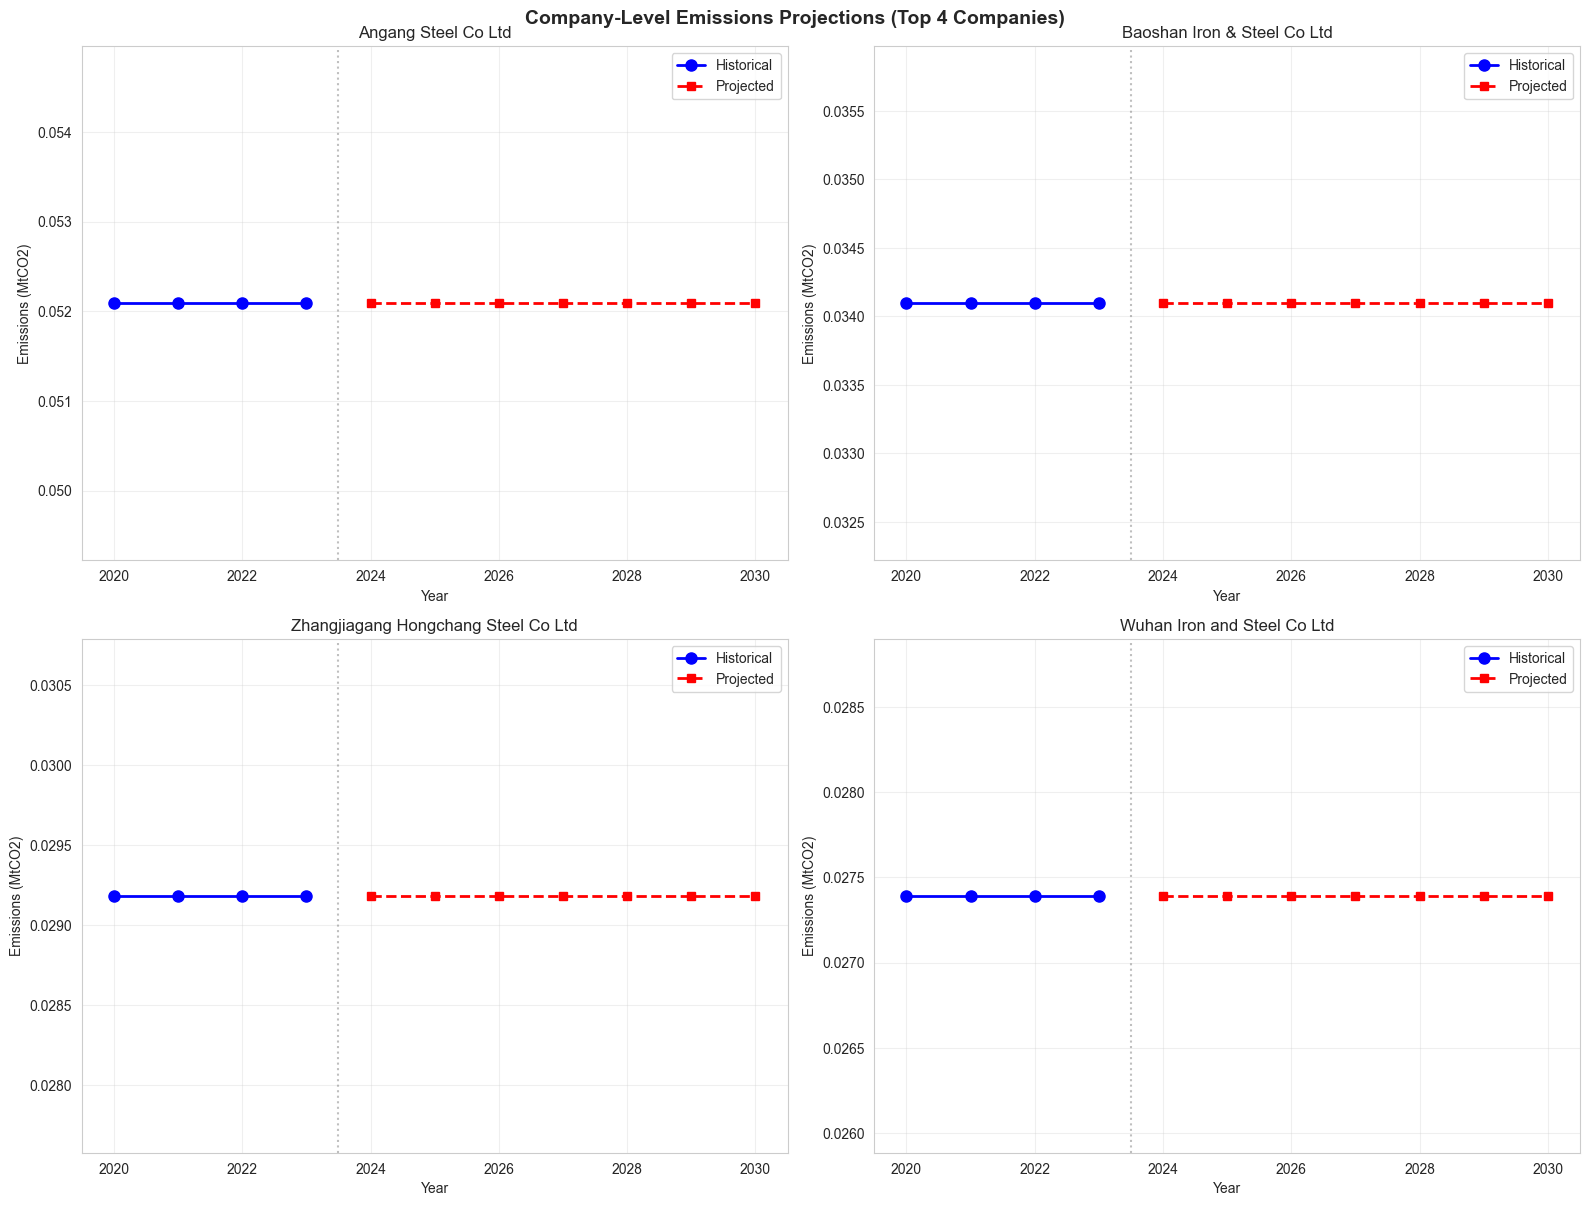

In [157]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

top_4_companies = list(top_companies[:4])

for idx, company in enumerate(top_4_companies):
    ax = axes[idx]
    
    company_proj = projection_df[projection_df['Owner'] == company]
    historical = company_proj[company_proj['type'] == 'historical']
    projected = company_proj[company_proj['type'] == 'projected']
    
    ax.plot(historical['year'], historical['emissions']/1e6, 
            marker='o', linewidth=2, markersize=8, label='Historical', color='blue')
    ax.plot(projected['year'], projected['emissions']/1e6, 
            marker='s', linewidth=2, markersize=6, linestyle='--', label='Projected', color='red')
    
    ax.axvline(x=2023.5, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Year')
    ax.set_ylabel('Emissions (MtCO2)')
    ax.set_title(f'{company}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Company-Level Emissions Projections (Top 4 Companies)', y=1.001, fontsize=14, fontweight='bold')
plt.show()

## 13. Visualization: Emissions by Technology

In [158]:
emissions_by_tech = df_china.groupby(['year', 'technology'])['emissions'].sum() / 1e6
emissions_pivot = emissions_by_tech.unstack()
print("\nEmissions by technology (MtCO2):")
print(emissions_pivot)


Emissions by technology (MtCO2):
technology    BF-BOF       EAF  Unknown
year                                   
2020        1.400973  0.033107      0.0
2021        1.422883  0.034713      0.0
2022        1.460375  0.034895      0.0
2023        1.460375  0.039117      0.0
2024        1.460375  0.039117      0.0
2025        1.460375  0.039117      0.0
2026        1.460375  0.039117      0.0
2027        1.460375  0.039117      0.0
2028        1.460375  0.039117      0.0
2029        1.460375  0.039117      0.0
2030        1.460375  0.039117      0.0


## 14. Visualization: Top 10 Companies

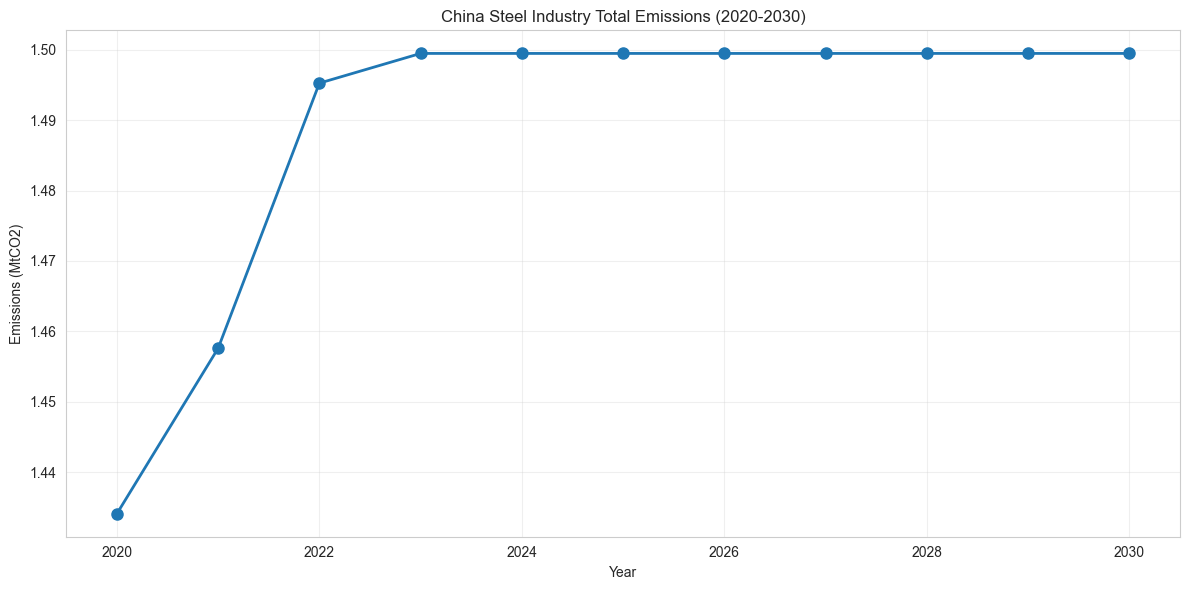

In [159]:
plt.figure(figsize=(12, 6))
plt.plot(total_emissions_by_year.index, total_emissions_by_year.values, 
         marker='o', linewidth=2, markersize=8)
plt.xlabel('Year')
plt.ylabel('Emissions (MtCO2)')
plt.title('China Steel Industry Total Emissions (2020-2030)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 15. Summary Statistics and Export

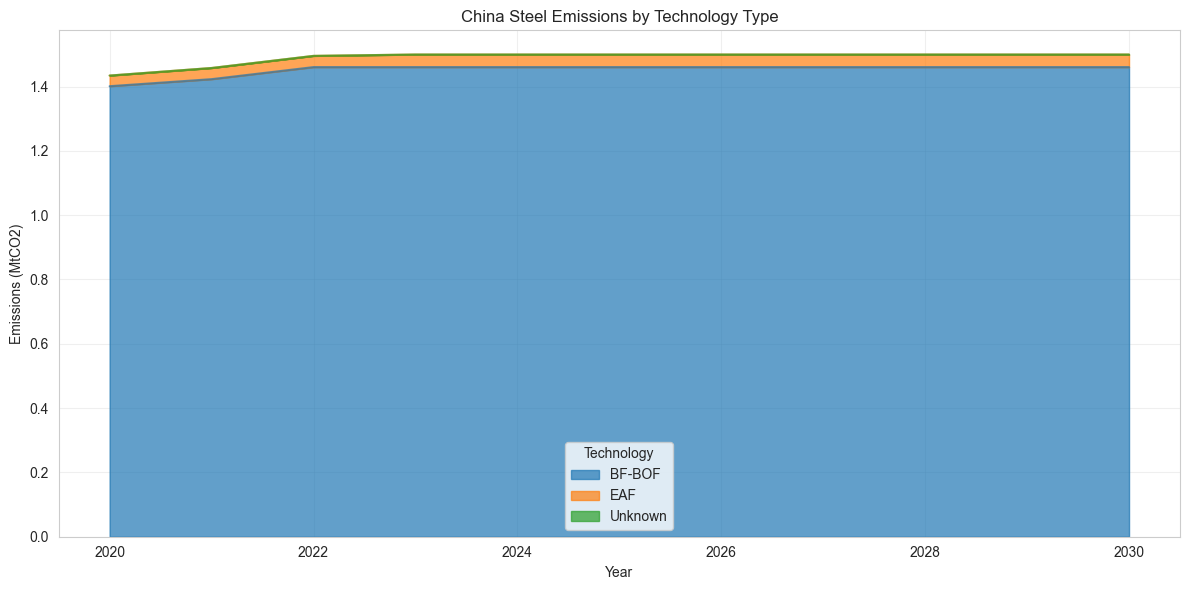

In [160]:
emissions_pivot.plot(kind='area', stacked=True, figsize=(12, 6), alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Emissions (MtCO2)')
plt.title('China Steel Emissions by Technology Type')
plt.legend(title='Technology')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 14. Company Emissions Trends

In [161]:
total_production = plant_emissions.groupby('year')['production'].sum() / 1e6
print("\nChina annual production (Mt):")
print(total_production)


China annual production (Mt):
year
2020    0.733343
2021    0.746989
2022    0.765207
2023    0.773651
2024    0.773651
2025    0.773651
2026    0.773651
2027    0.773651
2028    0.773651
2029    0.773651
2030    0.773651
Name: production, dtype: float64


In [162]:
summary = pd.DataFrame({
    'Year': total_emissions_by_year.index,
    'Total Emissions (MtCO2)': total_emissions_by_year.values,
    'Total Production (Mt)': total_production.values,
    'Emissions Intensity (tCO2/t steel)': total_emissions_by_year.values / total_production.values
})

print("\nChina Steel Industry Summary:")
print(summary)


China Steel Industry Summary:
    Year  Total Emissions (MtCO2)  Total Production (Mt)  \
0   2020                 1.434079               0.733343   
1   2021                 1.457596               0.746989   
2   2022                 1.495270               0.765207   
3   2023                 1.499492               0.773651   
4   2024                 1.499492               0.773651   
5   2025                 1.499492               0.773651   
6   2026                 1.499492               0.773651   
7   2027                 1.499492               0.773651   
8   2028                 1.499492               0.773651   
9   2029                 1.499492               0.773651   
10  2030                 1.499492               0.773651   

    Emissions Intensity (tCO2/t steel)  
0                             1.955537  
1                             1.951296  
2                             1.954073  
3                             1.938201  
4                             1.938201  
5 